<h1><center>Predict Dota2 winner<center><h1>

[Соревнование](https://www.kaggle.com/c/mlcourse-dota2-win-prediction)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import pickle
from collections import defaultdict
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit,\
                                    cross_val_score, cross_validate
import scipy.stats as stats
import gc
import warnings
warnings.filterwarnings('ignore')
import os
import category_encoders as ce
from tqdm import tqdm_notebook
import json
from itertools import combinations, groupby
from functools import reduce
from sklearn.cluster import KMeans
import time
from itertools import groupby
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from sklearn.feature_selection import RFECV
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

In [2]:
# функция для чтения json файлов
def read_matches(path_to_file):
    with open(path_to_file) as fin:
        for line in fin: 
            yield json.loads(line)

In [3]:
# пути к файлам, размеры файлов
PATH_TR, TOTAL_TR = 'train_matches.jsonl', 39675
PATH_TE, TOTAL_TE = 'test_matches.jsonl', 10000


In [4]:
types = []
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    for obj in MATCH['objectives']:
        types.append(obj['type'])
unqiue_types = np.unique(types)
topkeys = list(MATCH.keys())

print('{:^25}'.format('teamfights'))
print('-----------------------')
for idx, el in enumerate(list(MATCH['teamfights'][0].keys())):
    print('{}) {}'.format(idx+1, el))
for idx2, el2 in enumerate(list(MATCH['teamfights'][0]['players'][0].keys())):
    print('{:>4}.{}) {}'.format(5, idx2+1, el2)) 
print('-----------------------\n\n')

print('{:^35}'.format('objectives'))
print('-----------------------------------')
for idx3, tp in enumerate(unqiue_types):
    print('{:>4}) {}'.format(idx3+1, tp))  
print('-----------------------------------\n\n')

print('{:^55}'.format('players'))
print('------------------------------------------------------------')
for k, v in MATCH['players'][0].items():
    print('{:>25} {}'.format(k, type(v)))
print('------------------------------------------------------------')


       teamfights        
-----------------------
1) start
2) end
3) last_death
4) deaths
5) players
   5.1) deaths_pos
   5.2) ability_uses
   5.3) item_uses
   5.4) killed
   5.5) deaths
   5.6) buybacks
   5.7) damage
   5.8) healing
   5.9) gold_delta
   5.10) xp_delta
-----------------------


            objectives             
-----------------------------------
   1) CHAT_MESSAGE_AEGIS
   2) CHAT_MESSAGE_AEGIS_STOLEN
   3) CHAT_MESSAGE_BARRACKS_KILL
   4) CHAT_MESSAGE_DENIED_AEGIS
   5) CHAT_MESSAGE_FIRSTBLOOD
   6) CHAT_MESSAGE_ROSHAN_KILL
   7) CHAT_MESSAGE_TOWER_DENY
   8) CHAT_MESSAGE_TOWER_KILL
-----------------------------------


                        players                        
------------------------------------------------------------
              player_slot <class 'int'>
                  hero_id <class 'int'>
                hero_name <class 'str'>
          account_id_hash <class 'str'>
         ability_upgrades <class 'list'>
               obs_placed <c

#### Целевой признак

In [5]:
target_L = []
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):    
    target_L.append((MATCH['match_id_hash'], MATCH['targets']['radiant_win']))
y_tr = pd.DataFrame.from_records(target_L).set_index(0)[1].astype(int).values

#### Глобальные статы

In [6]:
globals_L = []
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    globals_L.append((MATCH['game_time'], MATCH['match_id_hash'],
                      MATCH['game_mode'], MATCH['lobby_type']))
glob_df = pd.DataFrame.from_records(globals_L)

In [7]:
empty_df = pd.DataFrame(index = glob_df[1])

#### Чат (длина переписки, интесивность переписки)

In [8]:
messages_L = []
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    for msg in MATCH['chat']:
        try:
            messages_L.append((MATCH['match_id_hash'], msg['player_slot']<100,\
                               np.abs(msg['time']), msg['text'].count('*')))
        except:
            pass
mess_df = pd.DataFrame.from_records(messages_L)
mess_df[4] = mess_df[1].replace({True:1, False:-1}) * mess_df[3]

X_tr = np.column_stack([glob_df.set_index(1),\
                        empty_df.join(mess_df.groupby(0)[4].sum()),\
                        empty_df.join(mess_df.groupby([0, 1])[2].apply(lambda x: np.diff(sorted(x)).mean()).unstack())])

#### Командные сражения

In [9]:
tf_D = defaultdict(list)
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    idx = MATCH['match_id_hash']
    for tf_idx, tf in enumerate(MATCH['teamfights']):
        tf_D['glob'].append((idx, tf_idx, abs(tf['start']), abs(tf['end']), abs(tf['last_death']), tf['deaths']))
        for player_idx, player in enumerate(tf['players']):
            team = 'r' if player_idx<=4 else 'd'            
            for k, v in player['deaths_pos'].items():
                for k2,v2 in v.items():
                    tf_D['deaths_pos'].append((idx, team, k, k2, v2))
            for key in ('ability_uses', 'item_uses', 'killed'):
                for k, v in player[key].items():
                    tf_D[key].append((idx, team, k, v))
            for key in ('deaths', 'buybacks', 'damage', 'healing', 'gold_delta', 'xp_delta'):
                tf_D[key].append((idx, team, player[key]))
                
df_tf_glob = pd.DataFrame.from_records(tf_D['glob'])
df_tf_glob.columns = ['idx', 'tf_idx', 'start', 'end', 'last_death', 'deaths']
df_tf_glob['duration'] = df_tf_glob['end'] - df_tf_glob['start']
tf_glob_df = empty_df.join(df_tf_glob.groupby('idx').size().to_frame('count'))\
    .join(df_tf_glob.groupby('idx')['duration'].mean().to_frame('duration_mean'))

df_tf_glob['start2'] = df_tf_glob['start'] // 60
for ts in np.unique(df_tf_glob['start2']):
    tf_glob_df = tf_glob_df.join(df_tf_glob[df_tf_glob['start2']<=ts].groupby('idx').size().to_frame(ts))
tf_glob_df = tf_glob_df.join(df_tf_glob.groupby('idx').apply(lambda x: np.mean(x['deaths'])\
                                                / np.sum(x['duration'])).to_frame('death_per_min_tf'))
L2_tf = []
for key in tqdm_notebook(('deaths', 'buybacks', 'damage', 'healing', 'gold_delta', 'xp_delta')):
    _df = pd.DataFrame.from_records(tf_D[key])
    _ddf = empty_df.join(_df.groupby([0, 1])[2].sum().unstack())    
    L2_tf.append(_ddf.iloc[:, 1] - _ddf.iloc[:, 0])
for key in tqdm_notebook(('ability_uses', 'item_uses', 'killed')):
    _df = pd.DataFrame.from_records(tf_D[key])
    _df[4] = _df[1].replace({'r':1, 'd':-1}) * _df[3]
    L2_tf.append(empty_df.join(_df.groupby([0, 2])[4].sum().unstack()))
    
tf_glob_df = pd.concat([tf_glob_df, pd.concat(L2_tf, 1)], 1)
_df = pd.DataFrame.from_records(tf_D['deaths_pos'])
_df[5] = _df[2].astype(str) +'_' + _df[3].astype(str)
_df[6] = _df[4] * _df[1].replace({'r':1, 'd':-1})

X_tr = np.column_stack([X_tr, empty_df.join(_df.groupby([0, 5])[6].sum().unstack())])

#### Обжективы (глобальные объекты на карте) (собираем мешок обжективов)

In [10]:
obj_L = []
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    idx = MATCH['match_id_hash']  
    for obj in MATCH['objectives']:
        obj['idx'] = idx
        obj_L.append(obj)
df = pd.DataFrame.from_records(obj_L)

df.loc[df['team'].isna(), 'flag'] = df[df['team'].isna()]['player_slot'].apply(lambda x: 2 if x<100 else 3)
df.loc[~df['team'].isna(), 'flag'] = df[~df['team'].isna()]['team']
df.loc[df['flag'].isin([60, 100]), 'flag'] = df[df['flag'].isin([60, 100])]['slot'].apply(lambda x: 2 if x<=4 else 3)
df['flag'] = df['flag'].replace({2:1, 3:-1})

X_tr = np.column_stack([X_tr,\
                        empty_df.join(df.groupby(['idx', 'type'])['flag'].sum().unstack()).values])

#### Игроки (конечные числовые характеристики)

In [11]:
numbers = ['assists', 'camps_stacked', 'creeps_stacked', 'deaths', 'denies',
           'firstblood_claimed', 'gold', 'health',  'kills',
           'level', 'lh', 'max_health', 'max_mana',
           'nearby_creep_death_count', 'obs_placed', 'observers_placed',
           'roshans_killed','rune_pickups', 'sen_placed', 'stuns', 'teamfight_participation',
           'towers_killed', 'xp']
D_players = defaultdict(list)
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    idx = MATCH['match_id_hash']  
    for player_idx, player in enumerate(MATCH['players']):
        team = 'r' if player_idx<=4 else 'd'
        for key in numbers:
            D_players[key].append((idx, team, player[key]))

diffs_df = pd.DataFrame()
for k, v in tqdm_notebook(D_players.items()):
    _df = pd.DataFrame.from_records(v)
    diffs_df[k] = _df.groupby([0, 1])[2].mean().unstack().diff(axis = 1).iloc[:, -1]
X_tr  = np.column_stack([X_tr, empty_df.join(diffs_df)])
del diffs_df, D_players
gc.collect()
D_players = defaultdict(list)

#### Игроки (герои, координаты)

In [12]:
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    idx = MATCH['match_id_hash']  
    for player_idx, player in enumerate(MATCH['players']):
        team = 'r' if player_idx<=4 else 'd'
        for key in ('hero_id','x', 'y'):
            D_players[key].append((idx, team, player[key]))
            
hero_coords_L = [] 
for key in ('hero_id','x', 'y'):
    _df = pd.DataFrame.from_records(D_players[key])
    _df[1] = _df[1].replace({'r':1, 'd':-1})
    hero_coords_L.append(empty_df.join(_df.groupby([0, 2])[1].sum().unstack())) 
    
X_tr  = np.column_stack([X_tr, np.column_stack(hero_coords_L)])
del hero_coords_L
gc.collect()

4

#### Игроки (золото, ласт хиты, денаи, опыт с течением времени)

In [13]:
ts_keys = ['gold_t', 'xp_t', 'lh_t', 'dn_t']
ts_D = defaultdict(list)
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    idx = MATCH['match_id_hash']  
    for player_idx, player in enumerate(MATCH['players']):
        team = 'r' if player_idx<=4 else 'd'
        for key in ts_keys:
            for element_idx, element in enumerate(player[key]):
                ts_D[key].append((idx, team, element_idx, element))
                
ts_L = []
for k, v in tqdm_notebook(ts_D.items()):    
    _df = pd.DataFrame.from_records(v)
    _df[1] = _df[1].replace({'r':1, 'd':-1})
    _df[3] = _df[1] * _df[3]
    _df = _df.drop(1, axis = 1)
    ts_diffs= []
    for ts in np.unique(_df[2]):
        ts_diffs.append(empty_df.join(_df[_df[2] <= ts].groupby(0)[3].mean().to_frame()))
    ts_L.append(np.column_stack(ts_diffs))

X_tr  = np.column_stack([X_tr,np.column_stack(ts_L)])
del ts_D, ts_L
gc.collect()

12

#### Игроки (апгрейд умений)

In [14]:
abil_upgrades_L = []
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    idx = MATCH['match_id_hash']  
    for player_idx, player in enumerate(MATCH['players']):
        team = 'r' if player_idx<=4 else 'd'
        for upgrade in player['ability_upgrades']:
            upgrade['idx'] = idx
            upgrade['team'] = team
            abil_upgrades_L.append(upgrade)
_df = pd.DataFrame.from_records(abil_upgrades_L)
_df['time'] = _df['time'].abs()
L4 = []
for _idx, _subdf in tqdm_notebook(_df.groupby('idx')):
    _r = _subdf[_subdf['team'] == 'r'].sort_values('time')['time'].diff().mean()
    _d = _subdf[_subdf['team'] == 'd'].sort_values('time')['time'].diff().mean()
    L4.append((_idx, _r, _d))
_df['team'] = _df['team'].replace({'r':1, 'd':-1})

X_tr  = np.column_stack([X_tr,pd.concat([empty_df.join(_df.groupby(['idx', 'ability'])['team'].mean().unstack()),\
                                         empty_df.join(pd.DataFrame.from_records(L4))], 1)])
del abil_upgrades_L, _df, L4
gc.collect()

35502

#### Игроки (buyback:выкуп мертвого героя)

In [15]:
bb_log_L = []
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    idx = MATCH['match_id_hash']  
    for player_idx, player in enumerate(MATCH['players']):
        team = 'r' if player_idx<=4 else 'd'
        for bb_log in player['buyback_log']:
            bb_log_L.append((idx, ('r' if bb_log['player_slot'] < 100 else 'd'), np.abs(bb_log['time'])))
_df = pd.DataFrame.from_records(bb_log_L)
X_tr  = np.column_stack([X_tr,empty_df.join(_df.groupby([0, 1])[2].apply(lambda x: np.diff(sorted(x)).mean()).unstack())])
del bb_log_L, _df
gc.collect()

4

#### Игроки (hero inventory: инвентарь героя)

In [16]:
inv_L = []
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    idx = MATCH['match_id_hash']  
    for player_idx, player in enumerate(MATCH['players']):
        team = 'r' if player_idx<=4 else 'd'
        for item in player['hero_inventory']:
            try:
                inv_L.append((idx, team, item['id'], item['cooldown']))
            except:
                pass
_df = pd.DataFrame.from_records(inv_L)  
_df[4] = _df[3] * _df[1].replace({'r':1, 'd':-1})
X_tr  = np.column_stack([X_tr, empty_df.join(_df.groupby([0, 2])[4].sum().unstack())])
del inv_L, _df
gc.collect()

17

#### Игроки (kills log: логи убийств)

In [17]:
kl_L = []
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    idx = MATCH['match_id_hash']  
    for player_idx, player in enumerate(MATCH['players']):
        team = 'r' if player_idx<=4 else 'd'
        for log in player['kills_log']:
            kl_L.append((idx, team, np.abs(log['time'])))
            
_df = pd.DataFrame.from_records(kl_L)  
X_tr  = np.column_stack([X_tr, empty_df.join(_df.groupby([0, 1])[2].apply(lambda x: np.diff(sorted(x)).mean()).unstack())])
del kl_L, _df
gc.collect()

4

#### Игроки (purchase log: логи покупок)

In [18]:
pc_L = []
rn_L = []
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    idx = MATCH['match_id_hash']  
    for player_idx, player in enumerate(MATCH['players']):
        team = 'r' if player_idx<=4 else 'd'
        for log in player['purchase_log']:
            pc_L.append((idx, team, np.abs(log['time']), log['key']))
        for log in player['runes_log']:
            rn_L.append((idx, team, np.abs(log['time']), log['key']))
_df = pd.DataFrame.from_records(pc_L) 
_df[1] = _df[1].replace({'r':1, 'd':-1})
X_tr  = np.column_stack([X_tr, empty_df.join(_df.groupby([0, 3])[1].sum().unstack())])

_df = pd.DataFrame.from_records(rn_L) 
_df[1] = _df[1].replace({'r':1, 'd':-1})
X_tr  = np.column_stack([X_tr, empty_df.join(_df.groupby([0, 3])[1].sum().unstack())])

del pc_L, _df, rn_L
gc.collect()


4

#### Игроки (логи вардов)

In [19]:
D = defaultdict(list)
logs = ['obs_left_log', 'obs_log', 'sen_left_log', 'sen_log']
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    idx = MATCH['match_id_hash']  
    for player_idx, player in enumerate(MATCH['players']):
        team = 'r' if player_idx<=4 else 'd'
        for key in logs: 
            for element in player[key]:
                D[key].append((idx, team, str(element['x'] // 10)+'_'+str(element['y'] // 10)+'_'+str(element['z'] // 10)))
            
            
_logs_L = []
for k, v in tqdm_notebook(D.items()):
    _df = pd.DataFrame.from_records(v)
    _df[1] = _df[1].replace({'r':1, 'd':-1})
    _logs_L.append(empty_df.join(_df.groupby([0, 2])[1].sum().unstack()))   
    
X_tr  = np.column_stack([X_tr, np.column_stack(_logs_L)])
del D, _logs_L, _df
gc.collect()

79

#### Игроки (использованные умения, айтемы)

In [20]:
abil_uses_L = []
item_uses_L = []
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    idx = MATCH['match_id_hash']  
    for player_idx, player in enumerate(MATCH['players']):
        team = 'r' if player_idx<=4 else 'd'
        for k, v in player['ability_uses'].items():
            abil_uses_L.append((idx, team, k, v))
        for k, v in player['item_uses'].items():
            item_uses_L.append((idx, team, k, v))
_df = pd.DataFrame.from_records(abil_uses_L)
_df[1] = _df[1].replace({'r':1, 'd':-1})
_df[4] = _df[1]*_df[3]

_df2 = pd.DataFrame.from_records(item_uses_L)
_df2[1] = _df2[1].replace({'r':1, 'd':-1})
_df2[4] = _df2[1]*_df2[3]

X_tr = np.column_stack([X_tr, pd.concat([empty_df.join(_df.groupby([0, 2])[4].sum().unstack()),\
                                         empty_df.join(_df2.groupby([0, 2])[4].sum().unstack())], 1)])        

#### Игроки (действия, причины получения золотта, серии убийств, мульти убийства, пинги, причины получения опыта)

In [21]:
LL = ['actions', 'gold_reasons', 'kill_streaks', 'life_state', 'multi_kills', 'pings', 'xp_reasons']
D = defaultdict(list)
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    idx = MATCH['match_id_hash']  
    for player_idx, player in enumerate(MATCH['players']):
        team = 'r' if player_idx<=4 else 'd'
        for key in LL:
            for k, v in player[key].items():
                D[key].append((idx, team, k, v))
_dfs = []
for k, v in D.items():
    _df = pd.DataFrame.from_records(v)
    _df[4] = _df[1].replace({'r':1, 'd':-1}) * _df[3]
    _dfs.append(empty_df.join(_df.groupby([0, 2])[4].sum().unstack()))
    
X_tr = np.column_stack([X_tr,pd.concat(_dfs, 1)])
del D, _dfs, _df
gc.collect()

4

#### Игроки (урон)

In [22]:
dmg_L = []
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    idx = MATCH['match_id_hash']
    for player_idx, player in enumerate(MATCH['players']):
        team = 'r' if player_idx<=4 else 'd'   
        for k, v in player['damage'].items():
            dmg_L.append((idx, team, k, v))
_df = pd.DataFrame.from_records(dmg_L)  
_df[4] = _df[1].replace({'r':1, 'd':-1}) * _df[3]
X_tr = np.column_stack([X_tr,empty_df.join(_df.groupby([0, 2])[4].sum().unstack())])

In [23]:
print('Кол-во признаков == {}'.format(X_tr.shape[1]))

Кол-во признаков == 6618


In [28]:
# with open('X_tr.pickle', 'wb') as f:
#     pickle.dump(X_tr, f)
# with open('y_tr.pickle', 'wb') as f:
#     pickle.dump(y_tr, f)

In [4]:
with open('X_tr.pickle', 'rb') as f:
    X_tr = pickle.load(f)
with open('y_tr.pickle', 'rb') as f:
    y_tr = pickle.load(f)

#### Отбираем признаки

In [ ]:
def _select_features(estimator, X, y, cv, scoring, holdout_share, stratify, seed):
    
    '''Рекурсивно отбирает признаки (в соответствии с метриками на валидационной и на отложенной выборках)'''
    
    ############################################################################################################
    def _get_val_holdout_scores(estimator, _X_TR, _X_HOLDOUT, Y_TR, Y_HOLDOUT, cv, metric):
        mean_cv = cross_validate(estimator, _X_TR, Y_TR, cv = cv, scoring = metric)['test_score'].mean()
        estimator.fit(X_TR[:, current_features], Y_TR)
        Y_PREDPROB = estimator.predict_proba(_X_HOLDOUT)[:, 1]
        Y_PRED = estimator.predict(_X_HOLDOUT)[:, 1]
        if metric == 'roc_auc':
            holdout = roc_auc_score(Y_HOLDOUT, Y_PREDPROB)
        if metric == 'accuracy':
            holdout = accuracy_score(Y_HOLDOUT, Y_PRED)
        if metric == 'precision':
            holdout = precision_score(Y_HOLDOUT, Y_PRED)
        if metric == 'recall':
            holdout = recall_score(Y_HOLDOUT, Y_PRED)
        if metric == 'f1':
            holdout = f1_score(Y_HOLDOUT, Y_PRED)
        return (mean_cv, holdout)
    #################################################################################################################
    
    _X, _y = np.array(X), np.array(y)
    if stratify:
        # разбиваем данные на трейн и отложенную части, сохраняя пропорции таргета
        X_TR, X_HOLDOUT, Y_TR, Y_HOLDOUT = train_test_split(_X, _y, stratify = _y,\
                                                            test_size = holdout_share,\
                                                            random_state = seed, shuffle = True)
    else:
        X_TR, X_HOLDOUT, Y_TR, Y_HOLDOUT = train_test_split(_X, _y, test_size = holdout_share)
        
    # считаем валидацию каждого признака
    scores = []
    for i in tqdm_notebook(range(X_TR.shape[1])):
        mean_cv = cross_validate(lgb_est, X_TR[:, i].reshape(-1,1), Y_TR, cv = skf3, scoring = 'roc_auc')['test_score'].mean()
        scores.append(mean_cv)

    # сортируем признаки в порядке убывания валидации
    order = np.argsort(scores)[::-1]

    # лучший набор, лучшая валидация, лучшая отложенная
    # бесполезные признаки до и после повторного отбора 
    best_features, best_cv, best_holdout, to_drop_before, to_drop_after = [], .5, .5, [], []

    # по признакам в порядке убывания валидации
    for i in tqdm_notebook(order):

        # добавляем к писку лучших
        current_features = best_features+[i]

        # валидация, отложенная
        mean_cv, holdout = _get_val_holdout_scores(estimator, X_TR[:, current_features], X_HOLDOUT[:, current_features],\
                                                   Y_TR, Y_HOLDOUT, cv=cv, metric=scoring)

        # если оба скора растут
        if (mean_cv>best_cv) & (holdout>best_holdout):
            # обновляем лучшие скоры, лучшие признаки
            best_cv = mean_cv
            best_holdout = holdout
            best_features = current_features
        else:
            # если скоры не растут, добавляем признак в претенденты на удаление
            to_drop_before.append(i)

    # пока списки кандидатов на удаление ДО и ПОСЛЕ отбора не перестанут изменяться
    while True:   

        # добавляем очередной признак
        for i in tqdm_notebook(to_drop_before):
            current_features = best_features+[i]
            
            # валидация, отложенная
            mean_cv, holdout = _get_val_holdout_scores(estimator, X_TR[:, current_features], X_HOLDOUT[:, current_features],\
                                                       Y_TR, Y_HOLDOUT, cv=cv, metric=scoring)
            
            if (mean_cv>best_cv) & (holdout>best_holdout):
                best_cv = mean_cv
                best_holdout = holdout
                best_features = current_features
            else:
                # выбрасываем, если он не дал улучшений
                to_drop_after.append(i)

        # если списки признаков до и после отбора не изменились, прекращаем отбор
        if len(to_drop_before) == len(to_drop_after):
            break
        else:
            # список до --> список после, список после - пустой
            to_drop_before = to_drop_after
            to_drop_after = []   
            
    return (best_cv, best_holdout, best_features)
    

In [ ]:
SEED = 13
best_cv, best_holdout, best_features = _select_features(estimator=LGBMClassifier(random_state = SEED),\
                                                        X=X_tr, y=y_tr,\
                                                        cv=StratifiedKFold(3, random_state = SEED),\
                                                        scoring='roc_auc',\
                                                        holdout_share=.2, stratify=True, seed=SEED)

In [ ]:
X_selected_tr = X_tr[:, best_features]

In [31]:
print('auc на валидации = {}\nauc на отложенной = {}'.format(best_cv, best_holdout))

валидация = 0.8332850212086367
отложенная = 0.83517680812378


#### Оптимизация гиперпараметров

In [77]:
best_params_d = {}
convergence_grid = {'learning_rate' : np.linspace(.005, .1, 100).tolist(),              
                    'n_estimators': [100, 500]}
best_score = .5
for lr in tqdm_notebook(convergence_grid['learning_rate']):
    for n_estimators in tqdm_notebook(convergence_grid['n_estimators']):
    mean_score = cross_validate(LGBMClassifier(random_state = SEED, learning_rate = lr,\
                                               n_estimators =n_estimators),\
                       X_selected_tr, y_tr,\
                       scoring = 'roc_auc',\
                       cv = StratifiedKFold(3, random_state = SEED))['test_score'].mean()        
    if mean_score>best_score:
        best_score = mean_score
        best_lr = lr
        best_n_estimators = n_estimators
best_params_d['n_estimators'] = best_n_estimators
best_params_d['learning_rate'] = best_lr

complexity_grid = {'max_depth' : [3, 5, 7, 9, 25, 50, 75, 110, 130],\
                   'num_leaves': [2**power for power in range(2, 10)],\
                   'min_child_samples' : [20, 50, 100, 150, 250]}
for max_depth in tqdm_notebook(complexity_grid['max_depth']):
    for num_leaves in complexity_grid['num_leaves']:
        for min_child_samples in complexity_grid['min_child_samples']:
            est = LGBMClassifier(random_state = SEED, learning_rate = lr,\
                                 n_estimators =N, max_depth = max_depth,\
                                 num_leaves = num_leaves, min_child_samples = min_child_samples)
            mean_score = cross_validate(est,\
                       X_selected_tr, y_tr,\
                       scoring = 'roc_auc',\
                       cv = StratifiedKFold(3, random_state = SEED))['test_score'].mean() 
            if mean_score>best_score:                
                best_score = mean_score
                best_max_depth = max_depth
                best_num_leaves = num_leaves
                best_min_child_samples = min_child_samples        
best_params_d['max_depth'] = best_max_depth
best_params_d['num_leaves'] = best_num_leaves
best_params_d['min_child_samples'] = best_min_child_samples

In [116]:
print('1) auc(после оптимизациии lightgbm) = {}\n'.format(best_score))

print('2) оптимизация гиперпараметров для lightgbm\n')
print('\t{:^17} | {}'.format('параметр', 'значение'))
print('\t-----------------------------')
for k, v in best_params_d.items():
    print('\t{:<17} | {:.3f}'.format(k, v))

1) auc(после оптимизациии lightgbm) = 0.834689319792246

2) оптимизация гиперпараметров для lightgbm

	    параметр      | значение
	-----------------------------
	n_estimators      | 500.000
	learning_rate     | 0.014
	max_depth         | 3.000
	num_leaves        | 4.000
	min_child_samples | 150.000


In [120]:
targets_L =[]
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    MATCH['targets']['idx'] = MATCH['match_id_hash']
    targets_L.append(MATCH['targets'])
targets_df = pd.DataFrame.from_records(targets_L).set_index('idx')

#### Соберем таймстемпы всех событий в матче

In [334]:
timestamps_d = defaultdict(list)

for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    idx = MATCH['match_id_hash']
    try:
        for mess in MATCH['chat']:
            timestamps_d[idx].append(np.abs(mess['time']))
    except:
        pass
    for tf in MATCH['teamfights']:
        timestamps_d[idx].append(np.abs(tf['start']))

    for obj in MATCH['objectives']:
        timestamps_d[idx].append(np.abs(obj['time']))

    for player in MATCH['players']:
        for k, v in player.items():
            if isinstance(v, dict):
                for k2, v2 in v.items():
                    if k2 == 'time':
                        timestamps_d[idx].append(np.abs(v2))
            if isinstance(v, list):
                for el in v:
                    if isinstance(el, dict):
                        for k2, v2 in el.items():
                            if k2 =='time':
                                timestamps_d[idx].append(np.abs(v2))
for k, v in timestamps_d.items():
    timestamps_d[k] = np.unique(v) 
    
durations_L = []
for i in targets_df.index:    
    durations_L.append((max(timestamps_d[i]), targets_df.loc[i, 'duration']))
_df = pd.DataFrame.from_records(durations_L)
_df.index = targets_df.index
_df.columns = ['максимальная_временная_метка_сырые_данные', 'длительность_матча_организаторы']
_df['таргет'] = targets_df['radiant_win'].astype(int)
_df['убийство_рошана_организаторы'] = targets_df['next_roshan_team'].replace({None:np.nan})
roshan_kills_L = []
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    idx = MATCH['match_id_hash']
    for obj in MATCH['objectives']:
        if obj['type'] == 'CHAT_MESSAGE_ROSHAN_KILL':
            roshan_kills_L.append((idx, True))
_df = _df.join(pd.DataFrame.from_records(roshan_kills_L).set_index(0).rename(columns = {1:'убийство_рошана_сырые_данные'}))

_df['убийство_рошана_организаторы'] = _df['убийство_рошана_организаторы'].notna()

In [335]:
print('% совпавших значений убийства рошана (от организаторов, из описания матчей) = {:.0%}'\
      .format((_df['убийство_рошана_сырые_данные'].fillna(0) == _df['убийство_рошана_организаторы'].fillna(0)).mean()))
print('Похоже, организаторы в "убийство рошана" дали совершенно другую статистику')

% совпавших значений убийства рошана (от организаторов, из описания матчей) = 36%
Похоже, организаторы в "убийство рошана" дали совершенно другую статистику


		средние разные, alpha = .05


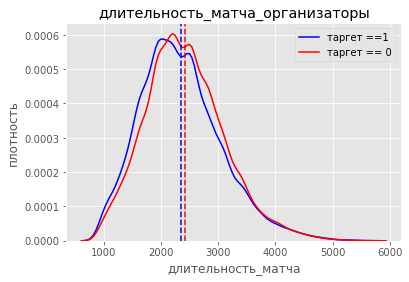

In [336]:
v1 = _df[_df['таргет'] == 1]['длительность_матча_организаторы']
v2 = _df[_df['таргет'] != 1]['длительность_матча_организаторы']
sns.kdeplot(v1, color = 'blue')
sns.kdeplot(v2, color = 'red')
plt.legend(['таргет ==1', 'таргет == 0'])
plt.axvline(v1.mean(), linestyle = '--', color = 'blue')
plt.axvline(v2.mean(), linestyle = '--', color = 'red')
plt.title('длительность_матча_организаторы')
plt.xlabel('длительность_матча')
plt.ylabel('плотность')

low1, high1 = np.percentile(np.mean(np.random.choice(v2.values, (1000, 100)), 1), [.025, .975])
low2, high2 = np.percentile(np.mean(np.random.choice(v1.values, (1000, 100)), 1), [.025, .975])
if ((low1<low2) & (high1<low2)) | ((low2<low1) & (high2<low1)):
    print('\t\tсредние разные, alpha = .05')
else:
    print('\t\tсредние одинаковые, alpha = .05')
    
_df['длительность_матча_организаторы_минуты'] =(_df['длительность_матча_организаторы']/60)round().astype(int)
mean_counts_df = _df.groupby('длительность_матча_организаторы_минуты')['таргет'].agg({'mean', 'count'})

#### длительность матча начинает сильно влиять на его результат с ~50 минуты

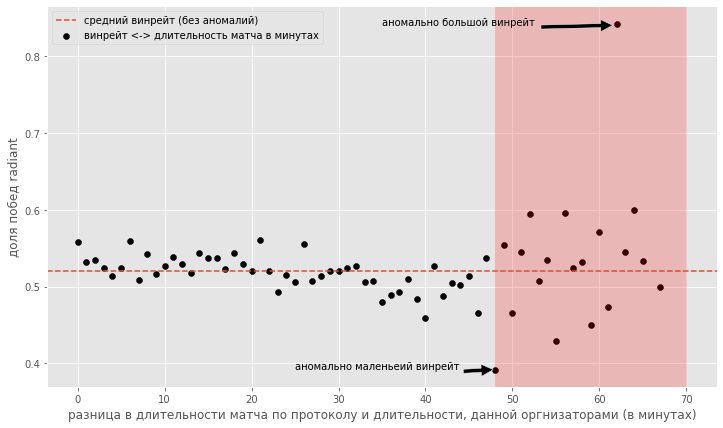

In [346]:
ser = mean_counts_df[mean_counts_df['count'] >= 10]['mean'].sort_values(ascending= False)
fig, ax = plt.subplots(figsize = (12, 7))
for k, v in ser.items():
    plt.scatter(k, v, color = 'black')
plt.xlabel('разница в длительности матча по протоколу и длительности, данной оргнизаторами (в минутах)')
plt.ylabel('доля побед radiant')
ax.annotate('аномально большой винрейт', xy=(62, .84), xytext=(35, .84),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
ax.annotate('аномально маленьеий винрейт', xy=(48, 0.392), xytext=(25, 0.392),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
q25, q75 = ser.quantile([.25, .75])
iqr = q75-q25
plt.axhline(ser[(ser > q25-1.5*iqr) & (ser < q75+1.5*iqr)].mean(), linestyle = '--')
plt.legend(['средний винрейт (без аномалий)', 'винрейт <-> длительность матча в минутах'])
plt.axvspan(48, 70, alpha = .2, color = 'red')
plt.show()    

In [349]:
obj_L = []
for MATCH in tqdm_notebook(read_matches(PATH_TR), total = TOTAL_TR):
    idx = MATCH['match_id_hash']  
    for obj in MATCH['objectives']:
        obj['idx'] = idx
        obj_L.append(obj)
df = pd.DataFrame.from_records(obj_L)

df.loc[df['team'].isna(), 'flag'] = df[df['team'].isna()]['player_slot'].apply(lambda x: 2 if x<100 else 3)
df.loc[~df['team'].isna(), 'flag'] = df[~df['team'].isna()]['team']
df.loc[df['flag'].isin([60, 100]), 'flag'] = df[df['flag'].isin([60, 100])]['slot'].apply(lambda x: 2 if x<=4 else 3)
df['flag'] = df['flag'].replace({2:1, 3:-1})

df_obj_counts = df.groupby(['idx', 'flag']).size().unstack()
df_obj_counts = df_obj_counts.join(targets_df['duration'].to_frame('длительность'))
df_obj_counts = df_obj_counts.rename(columns = {-1:'d', 1:'r'})
df_obj_counts = df_obj_counts.join(targets_df['time_remaining'].to_frame('длительность2'))

In [387]:
# with open('X_selected_tr.pickle', 'wb') as f:
#     pickle.dump(X_selected_tr, f)

In [ ]:
X_selected_tr

In [390]:
_to_add_df = targets_df[['duration', 'time_remaining', 'next_roshan_team']]
_to_add_df['next_roshan_team'] = _to_add_df['next_roshan_team'].replace({None:'other'}).factorize()[0]

In [392]:
X_sel2_tr = np.column_stack([X_selected_tr, _to_add_df])

In [393]:
mean_score = cross_validate(LGBMClassifier(random_state = SEED),\
                       X_sel2_tr, y_tr,\
                       scoring = 'roc_auc',\
                       cv = StratifiedKFold(3, random_state = SEED))['test_score'].mean() 

In [399]:
print('auc на валидации с признаками, данными организаторами(отсутсвуют в сырых файлах) = {}'.format(mean_score))
print('auc первого места = 0.86')

auc на валидации с признаками, данными организаторами(отсутсвуют в сырых файлах) = 0.8953176130444199
auc первого места = 0.86
